# VCC-project Demo: Exploring Perturb-seq Data

This notebook demonstrates how to explore and analyze the demo dataset from Replogle et al. 2022.

**Dataset**: K562 cells with CRISPRi perturbations (~10k cells, ~150 perturbations)

**Learning objectives**:
1. Load and inspect processed data
2. Visualize QC metrics
3. Explore perturbation effects
4. Compare train/val/test splits
5. Analyze feature engineering results

## Setup

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
# matplotlib.use('Agg') # Non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

warnings.filterwarnings('ignore')

# plt.ioff()  # Turn off interactive mode

# Scanpy settings
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

# Plot settings
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print("✓ Libraries loaded")
print(f"Scanpy version: {sc.__version__}")

✓ Libraries loaded
Scanpy version: 1.11.5


## 1. Load Demo Data

First, let's check if the demo data has been downloaded and processed.

In [2]:
# Check if data exists
data_path = Path("../data_local/demo/replogle_subset.h5ad")
metadata_path = Path("../data_local/demo/metadata.json")

if not data_path.exists():
    print("❌ Demo data not found!")
    print("\nPlease run: snakemake download_demo_data --cores 1")
else:
    print("✓ Demo data found")
    print(f"File size: {data_path.stat().st_size / 1e6:.1f} MB")
    
    # Load metadata
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print("\nDataset Info:")
        print(f"  Source: {metadata['source']}")
        print(f"  Cells: {metadata['n_cells']:,}")
        print(f"  Genes: {metadata['n_genes']:,}")
        print(f"  Perturbations: {metadata['n_perturbations']}")

✓ Demo data found
File size: 51.2 MB

Dataset Info:
  Source: Replogle et al. 2022 (via scPerturb/Zenodo)
  Cells: 10,000
  Genes: 8,563
  Perturbations: 150


In [3]:
# Load the data
adata = sc.read_h5ad(data_path)
print(adata)

AnnData object with n_obs × n_vars = 10000 × 8563
    obs: 'batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


## 2. Explore Data Structure

In [4]:
# Cell metadata
print("Cell metadata columns:")
print(adata.obs.columns.tolist())
print("\nFirst few cells:")
adata.obs.head()

Cell metadata columns:
['batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

First few cells:


batch     gene          gene_id transcript  \
cell_barcode                                                      
AAACCCACACCCAAGC-37     37    ZMAT2  ENSG00000146007         P1   
AAACCCACACTTTAGG-19     19  SLC39A9  ENSG00000029364       P1P2   
AAACCCAGTTCGCGTG-39     39     NUF2  ENSG00000143228       P1P2   
AAACGAAAGAGGATGA-1       1    SSRP1  ENSG00000149136       P1P2   
AAACGAAAGCGTTCAT-28     28    PRODH  ENSG00000100033         P2   

                                       gene_transcript  \
cell_barcode                                             
AAACCCACACCCAAGC-37     10136_ZMAT2_P1_ENSG00000146007   
AAACCCACACTTTAGG-19  8080_SLC39A9_P1P2_ENSG00000029364   
AAACCCAGTTCGCGTG-39     5878_NUF2_P1P2_ENSG00000143228   
AAACGAAAGAGGATGA-1     8458_SSRP1_P1P2_ENSG00000149136   
AAACGAAAGCGTTCAT-28      6782_PRODH_P2_ENSG00000100033   

                                                              guide_id  \
cell_barcode                                                             
AAACCCACACCCAAGC-37    ZMAT2_-_140080084.23-P1|ZMAT2_-_140080067.23-P1   
AAACCCACACTTTAGG-19  SLC39A9_+_69865454.23-P1P2|SLC39A9_-_69865448....   
AAACCCAGTTCGCGTG-39  NUF2_+_163291904.23-P1P2|NUF2_-_163291869.23-P1P2   
AAACGAAAGAGGATGA-1   SSRP1_-_57102976.23-P1P2|SSRP1_-_57103355.23-P1P2   
AAACGAAAGCGTTCAT-28      PRODH_+_18905892.23-P2|PRODH_+_18905874.23-P2   

                     percent_mito  UMI_count  z_gemgroup_UMI  \
cell_barcode                                                   
AAACCCACACCCAAGC-37      0.076150    23782.0        1.740771   
AAACCCACACTTTAGG-19      0.140546    17247.0        0.317306   
AAACCCAGTTCGCGTG-39      0.141516    19072.0        0.450479   
AAACGAAAGAGGATGA-1       0.139670     7217.0       -1.122577   
AAACGAAAGCGTTCAT-28      0.104265    12497.0        0.074353   

                     core_scale_factor  ...  perturbation_type tissue_type  \
cell_barcode                            ...                                  
AAACCCACACCCAAGC-37           1.023876  ...             CRISPR   cell_line   
AAACCCACACTTTAGG-19           1.123384  ...             CRISPR   cell_line   
AAACCCAGTTCGCGTG-39           1.127571  ...             CRISPR   cell_line   
AAACGAAAGAGGATGA-1            0.801973  ...             CRISPR   cell_line   
AAACGAAAGCGTTCAT-28           0.868942  ...             CRISPR   cell_line   

                     ncounts ngenes nperts  percent_ribo n_genes_by_counts  \
cell_barcode                                                                 
AAACCCACACCCAAGC-37  23410.0   4934      1      0.213071              4934   
AAACCCACACTTTAGG-19  17027.0   3856      1      0.221061              3856   
AAACCCAGTTCGCGTG-39  18712.0   4250      1      0.197200              4250   
AAACGAAAGAGGATGA-1    7108.0   2603      1      0.179235              2603   
AAACGAAAGCGTTCAT-28  12304.0   3481      1      0.221148              3481   

                    total_counts total_counts_mt pct_counts_mt  
cell_barcode                                                    
AAACCCACACCCAAGC-37      23410.0          1811.0      7.736010  
AAACCCACACTTTAGG-19      17027.0          2424.0     14.236214  
AAACCCAGTTCGCGTG-39      18712.0          2699.0     14.423900  
AAACGAAAGAGGATGA-1        7108.0          1008.0     14.181204  
AAACGAAAGCGTTCAT-28      12304.0          1303.0     10.590052  

[5 rows x 28 columns]

In [5]:
# Gene metadata
print("Gene metadata columns:")
print(adata.var.columns.tolist())
print("\nFirst few genes:")
adata.var.head()

Gene metadata columns:
['chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts']

First few genes:


chr   start      end           class strand  length  in_matrix  \
gene_name                                                                    
LINC01409  chr1  778747   810065  gene_version10      +   31318       True   
LINC01128  chr1  825138   868202   gene_version9      +   43064       True   
NOC2L      chr1  944203   959309  gene_version11      -   15106       True   
KLHL17     chr1  960584   965719  gene_version14      +    5135       True   
HES4       chr1  998962  1000172  gene_version10      -    1210       True   

               mean       std        cv      fano       ensembl_id   ncounts  \
gene_name                                                                      
LINC01409  0.137594  0.380048  2.762105  1.049733  ENSG00000237491   42707.0   
LINC01128  0.256720  0.520162  2.026184  1.053944  ENSG00000228794   79682.0   
NOC2L      1.975144  1.707837  0.864665  1.476706  ENSG00000188976  613055.0   
KLHL17     0.119593  0.353702  2.957540  1.046089  ENSG00000187961   37120.0   
HES4       0.249577  0.561933  2.251540  1.265214  ENSG00000188290   77465.0   

           ncells     mt  n_cells_by_counts  mean_counts  \
gene_name                                                  
LINC01409   39082  False               1302       0.1431   
LINC01128   68732  False               2208       0.2548   
NOC2L      248759  False               7895       1.9271   
KLHL17      34277  False               1031       0.1129   
HES4        62316  False               2040       0.2523   

           pct_dropout_by_counts  total_counts  
gene_name                                       
LINC01409                  86.98        1431.0  
LINC01128                  77.92        2548.0  
NOC2L                      21.05       19271.0  
KLHL17                     89.69        1129.0  
HES4                       79.60        2523.0

## 3. QC Metrics Visualization

In [6]:
# Check if QC metrics exist
if 'n_genes_by_counts' not in adata.obs.columns:
    print("Computing QC metrics...")
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
else:
    print("✓ QC metrics already computed")

✓ QC metrics already computed



QC Statistics:
Genes per cell: 3590 (median)
UMI counts: 12948 (median)
MT content: 10.68% (median)


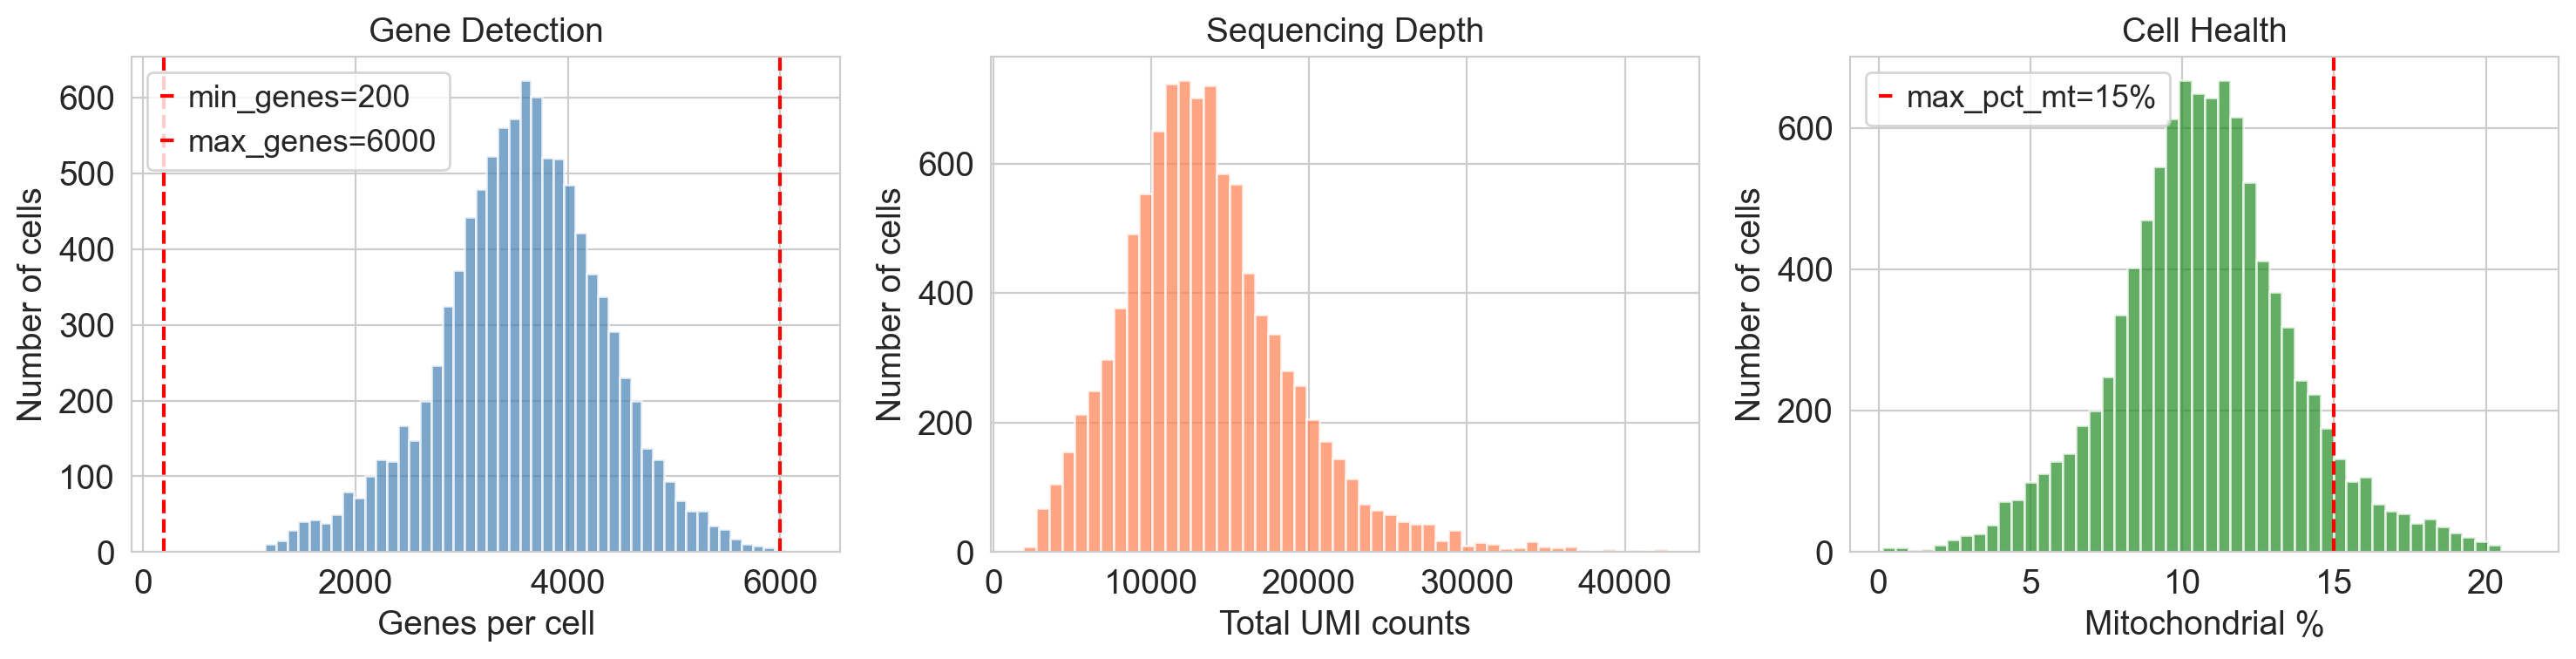

In [7]:
# Violin plots of QC metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Genes per cell
axes[0].hist(adata.obs['n_genes_by_counts'], bins=50, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Genes per cell')
axes[0].set_ylabel('Number of cells')
axes[0].set_title('Gene Detection')
axes[0].axvline(200, color='red', linestyle='--', label='min_genes=200')
axes[0].axvline(6000, color='red', linestyle='--', label='max_genes=6000')
axes[0].legend()

# UMI counts
axes[1].hist(adata.obs['total_counts'], bins=50, color='coral', alpha=0.7)
axes[1].set_xlabel('Total UMI counts')
axes[1].set_ylabel('Number of cells')
axes[1].set_title('Sequencing Depth')

# Mitochondrial content
axes[2].hist(adata.obs['pct_counts_mt'], bins=50, color='forestgreen', alpha=0.7)
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_ylabel('Number of cells')
axes[2].set_title('Cell Health')
axes[2].axvline(15, color='red', linestyle='--', label='max_pct_mt=15%')
axes[2].legend()

plt.tight_layout()
# plt.show()

# Print statistics
print("\nQC Statistics:")
print(f"Genes per cell: {adata.obs['n_genes_by_counts'].median():.0f} (median)")
print(f"UMI counts: {adata.obs['total_counts'].median():.0f} (median)")
print(f"MT content: {adata.obs['pct_counts_mt'].median():.2f}% (median)")

## 4. Perturbation Analysis

In [8]:
# Find perturbation column
possible_keys = ['gene', 'target_gene', 'target_gene_name', 'perturbation', 'gene_symbol']
pert_key = None
for key in possible_keys:
    if key in adata.obs.columns:
        pert_key = key
        break

if pert_key:
    print(f"✓ Found perturbation column: {pert_key}")
    
    # Perturbation distribution
    pert_counts = adata.obs[pert_key].value_counts()
    print(f"\nNumber of perturbations: {len(pert_counts)}")
    print(f"Cells per perturbation: {pert_counts.mean():.1f} ± {pert_counts.std():.1f}")
    print(f"Range: {pert_counts.min()} - {pert_counts.max()} cells")
else:
    print("⚠ Could not find perturbation column")
    print(f"Available columns: {adata.obs.columns.tolist()}")

✓ Found perturbation column: gene

Number of perturbations: 150
Cells per perturbation: 66.7 ± 117.3
Range: 32 - 1465 cells


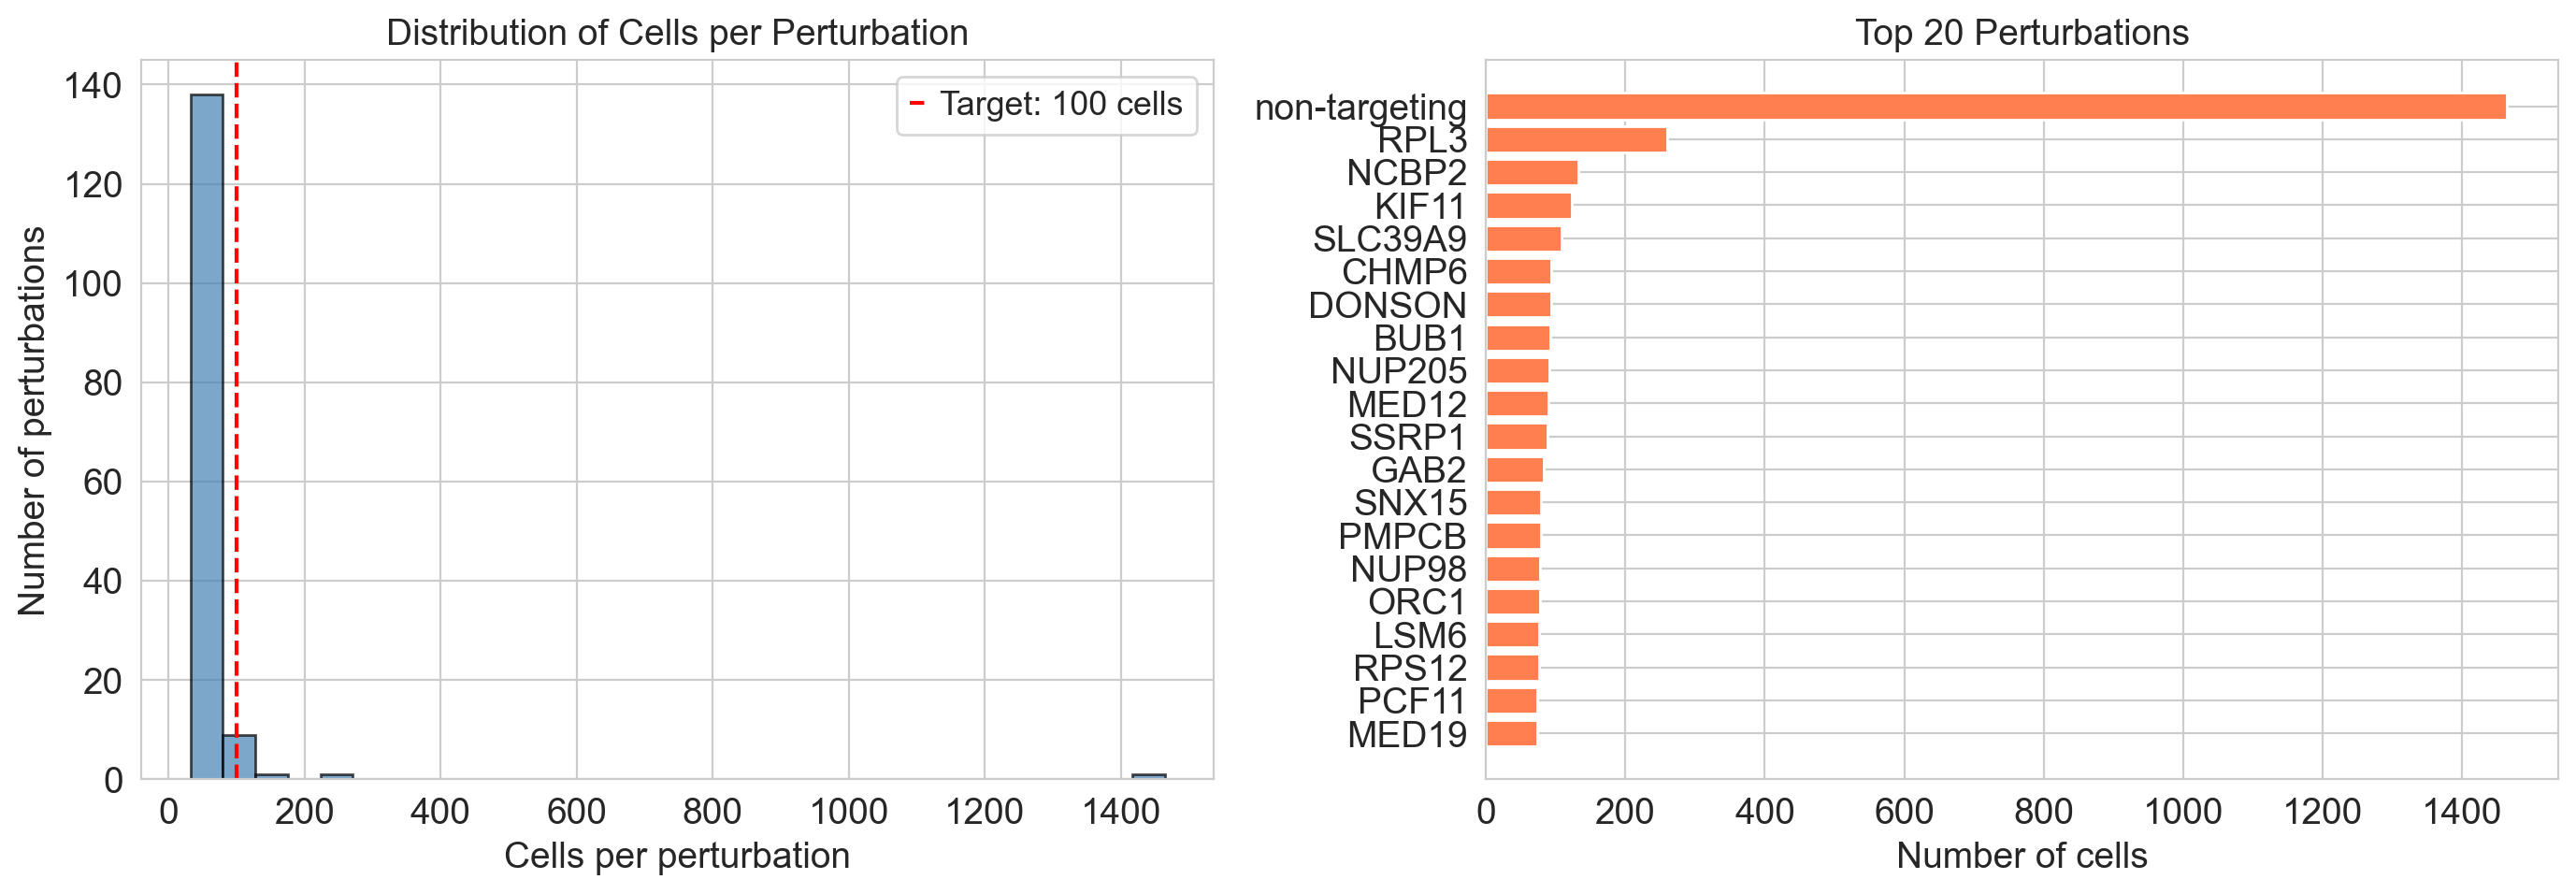

In [9]:
# Visualize perturbation distribution
if pert_key:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(pert_counts.values, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Cells per perturbation')
    axes[0].set_ylabel('Number of perturbations')
    axes[0].set_title('Distribution of Cells per Perturbation')
    axes[0].axvline(100, color='red', linestyle='--', label='Target: 100 cells')
    axes[0].legend()
    
    # Top 20 perturbations
    top20 = pert_counts.head(20)
    axes[1].barh(range(len(top20)), top20.values, color='coral')
    axes[1].set_yticks(range(len(top20)))
    axes[1].set_yticklabels(top20.index)
    axes[1].set_xlabel('Number of cells')
    axes[1].set_title('Top 20 Perturbations')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    # plt.show()

## 5. Dimensionality Reduction & Visualization

In [10]:
# Preprocessing for visualization
print("Running preprocessing pipeline...")

# Normalize and log-transform if not already done
if 'X_pca' not in adata.obsm.keys():
    # Work on a copy to preserve raw data
    adata_viz = adata.copy()
    
    # Normalize
    sc.pp.normalize_total(adata_viz, target_sum=1e4)
    sc.pp.log1p(adata_viz)
    
    # Find highly variable genes
    sc.pp.highly_variable_genes(adata_viz, n_top_genes=2000)
    
    # PCA
    sc.tl.pca(adata_viz, svd_solver='arpack')
    
    # Neighbors and UMAP
    sc.pp.neighbors(adata_viz, n_neighbors=15, n_pcs=30)
    sc.tl.umap(adata_viz)
    
    print("✓ Preprocessing complete")
else:
    adata_viz = adata
    print("✓ Using existing preprocessing")

Running preprocessing pipeline...
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:33)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)
✓ Preprocessing complete


Variance explained by first 30 PCs: 19.09%


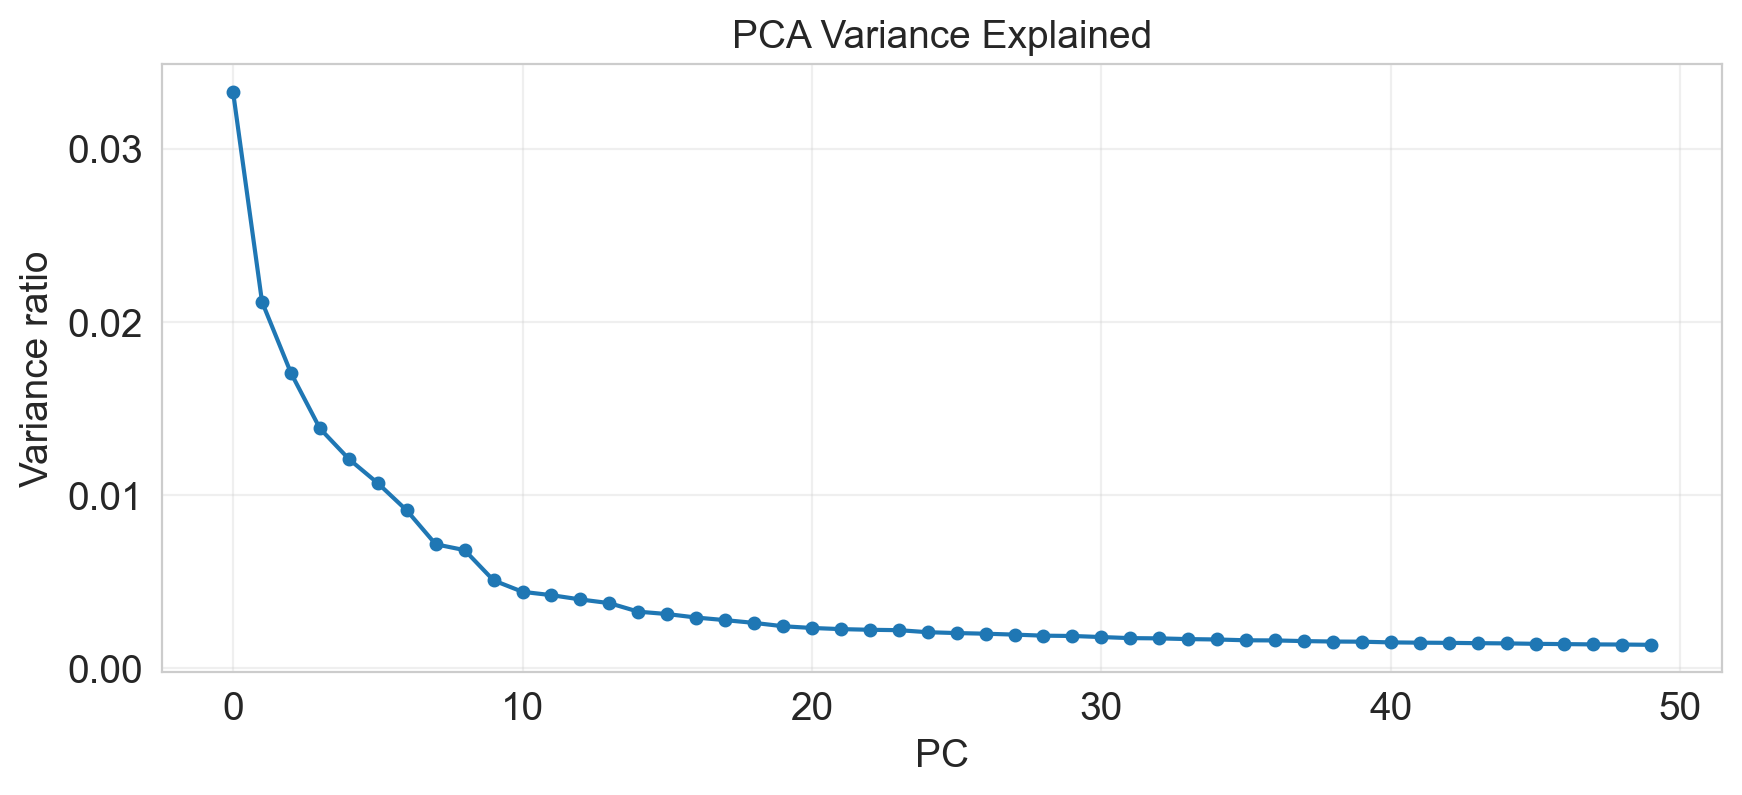

In [11]:
# PCA variance explained
plt.figure(figsize=(10, 4))
plt.plot(adata_viz.uns['pca']['variance_ratio'][:50], 'o-', markersize=4)
plt.xlabel('PC')
plt.ylabel('Variance ratio')
plt.title('PCA Variance Explained')
plt.grid(True, alpha=0.3)
# plt.show()

print(f"Variance explained by first 30 PCs: {adata_viz.uns['pca']['variance_ratio'][:30].sum():.2%}")

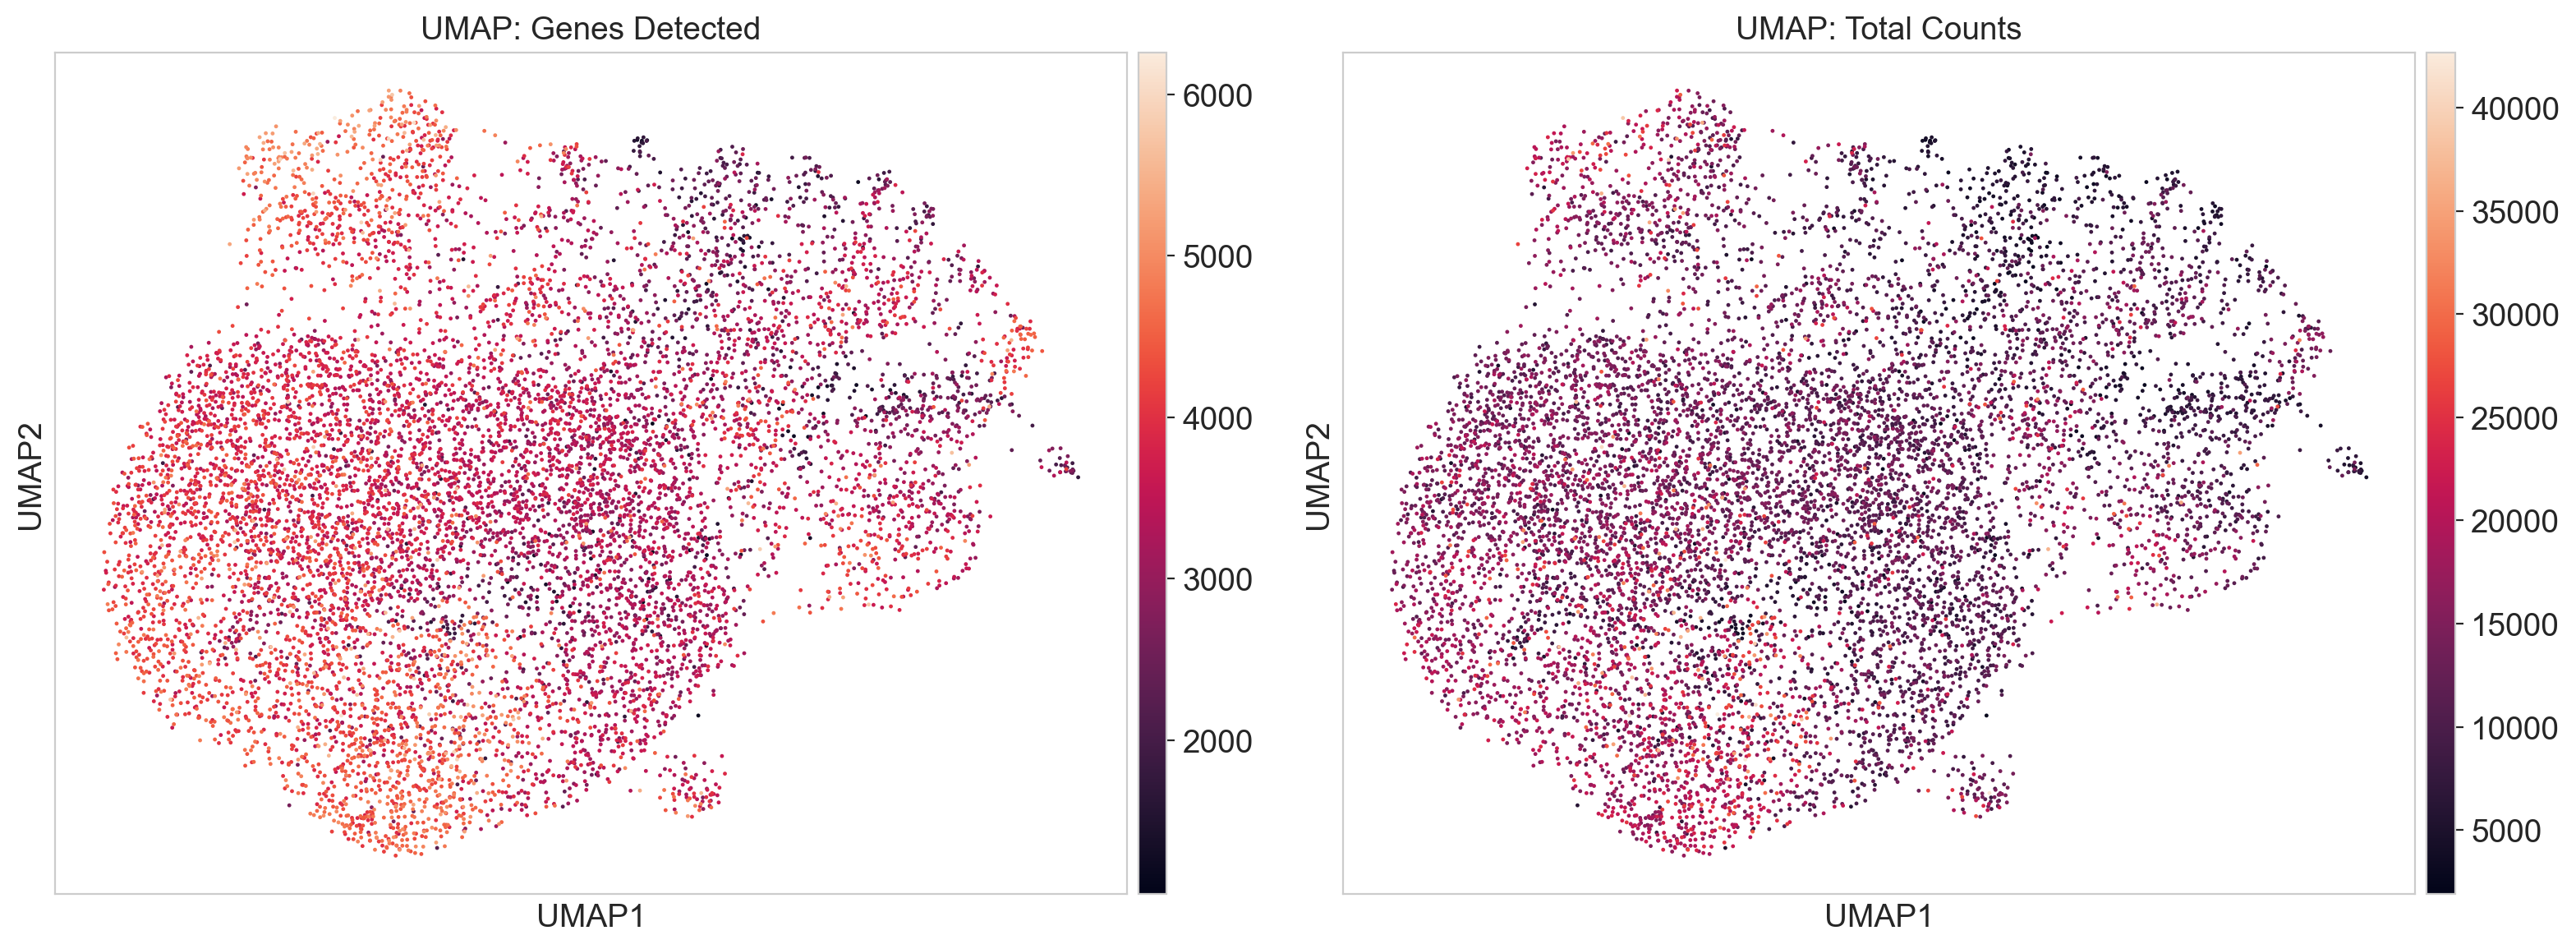

In [12]:
# UMAP visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Color by QC metrics
sc.pl.umap(adata_viz, color='n_genes_by_counts', ax=axes[0], show=False, 
           title='UMAP: Genes Detected')
sc.pl.umap(adata_viz, color='total_counts', ax=axes[1], show=False,
           title='UMAP: Total Counts')

plt.tight_layout()
# plt.show()

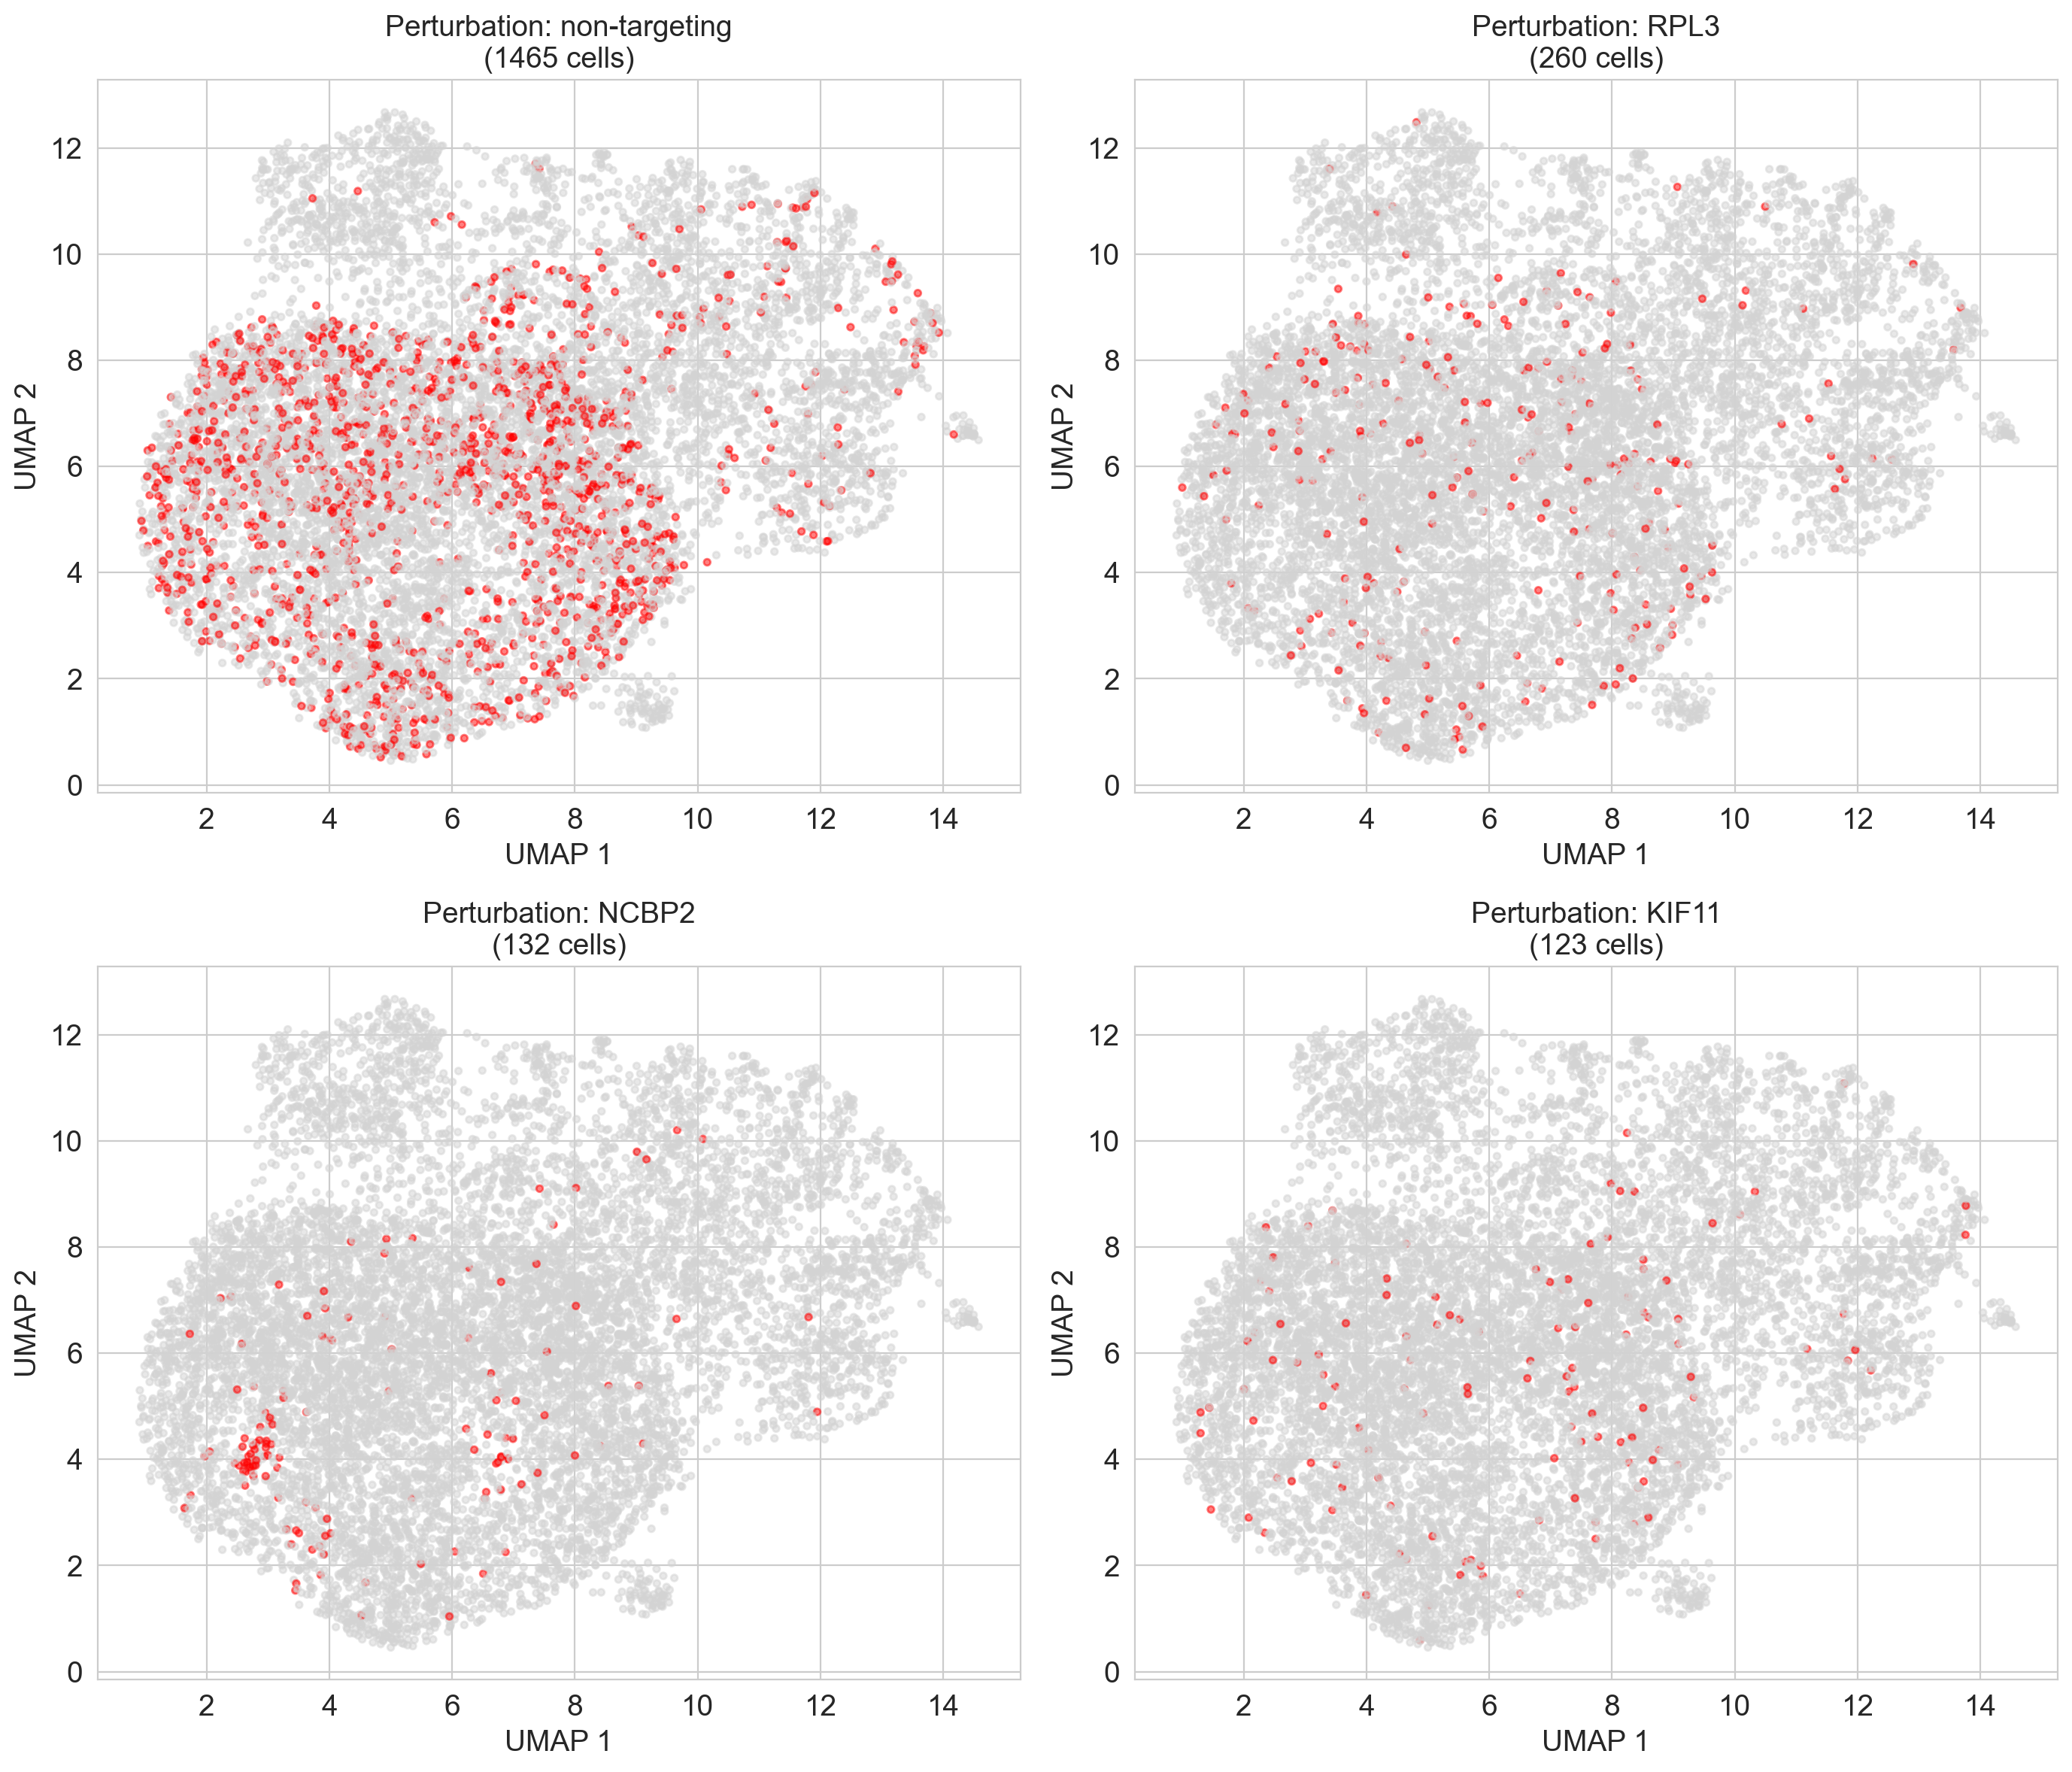

In [13]:
# Color by perturbation (showing a few interesting ones)
if pert_key:
    # Select 4 interesting perturbations
    interesting_perts = pert_counts.head(4).index.tolist()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, pert in enumerate(interesting_perts):
        # Highlight cells with this perturbation
        highlight = adata_viz.obs[pert_key] == pert
        
        axes[i].scatter(adata_viz.obsm['X_umap'][:, 0], 
                       adata_viz.obsm['X_umap'][:, 1],
                       c=['red' if h else 'lightgray' for h in highlight],
                       s=10, alpha=0.5)
        axes[i].set_title(f'Perturbation: {pert}\n({highlight.sum()} cells)')
        axes[i].set_xlabel('UMAP 1')
        axes[i].set_ylabel('UMAP 2')
    
    plt.tight_layout()
    # plt.show()

## 6. Gene Expression Analysis

Found 3 marker genes: ['KIT', 'MYC', 'GAPDH']


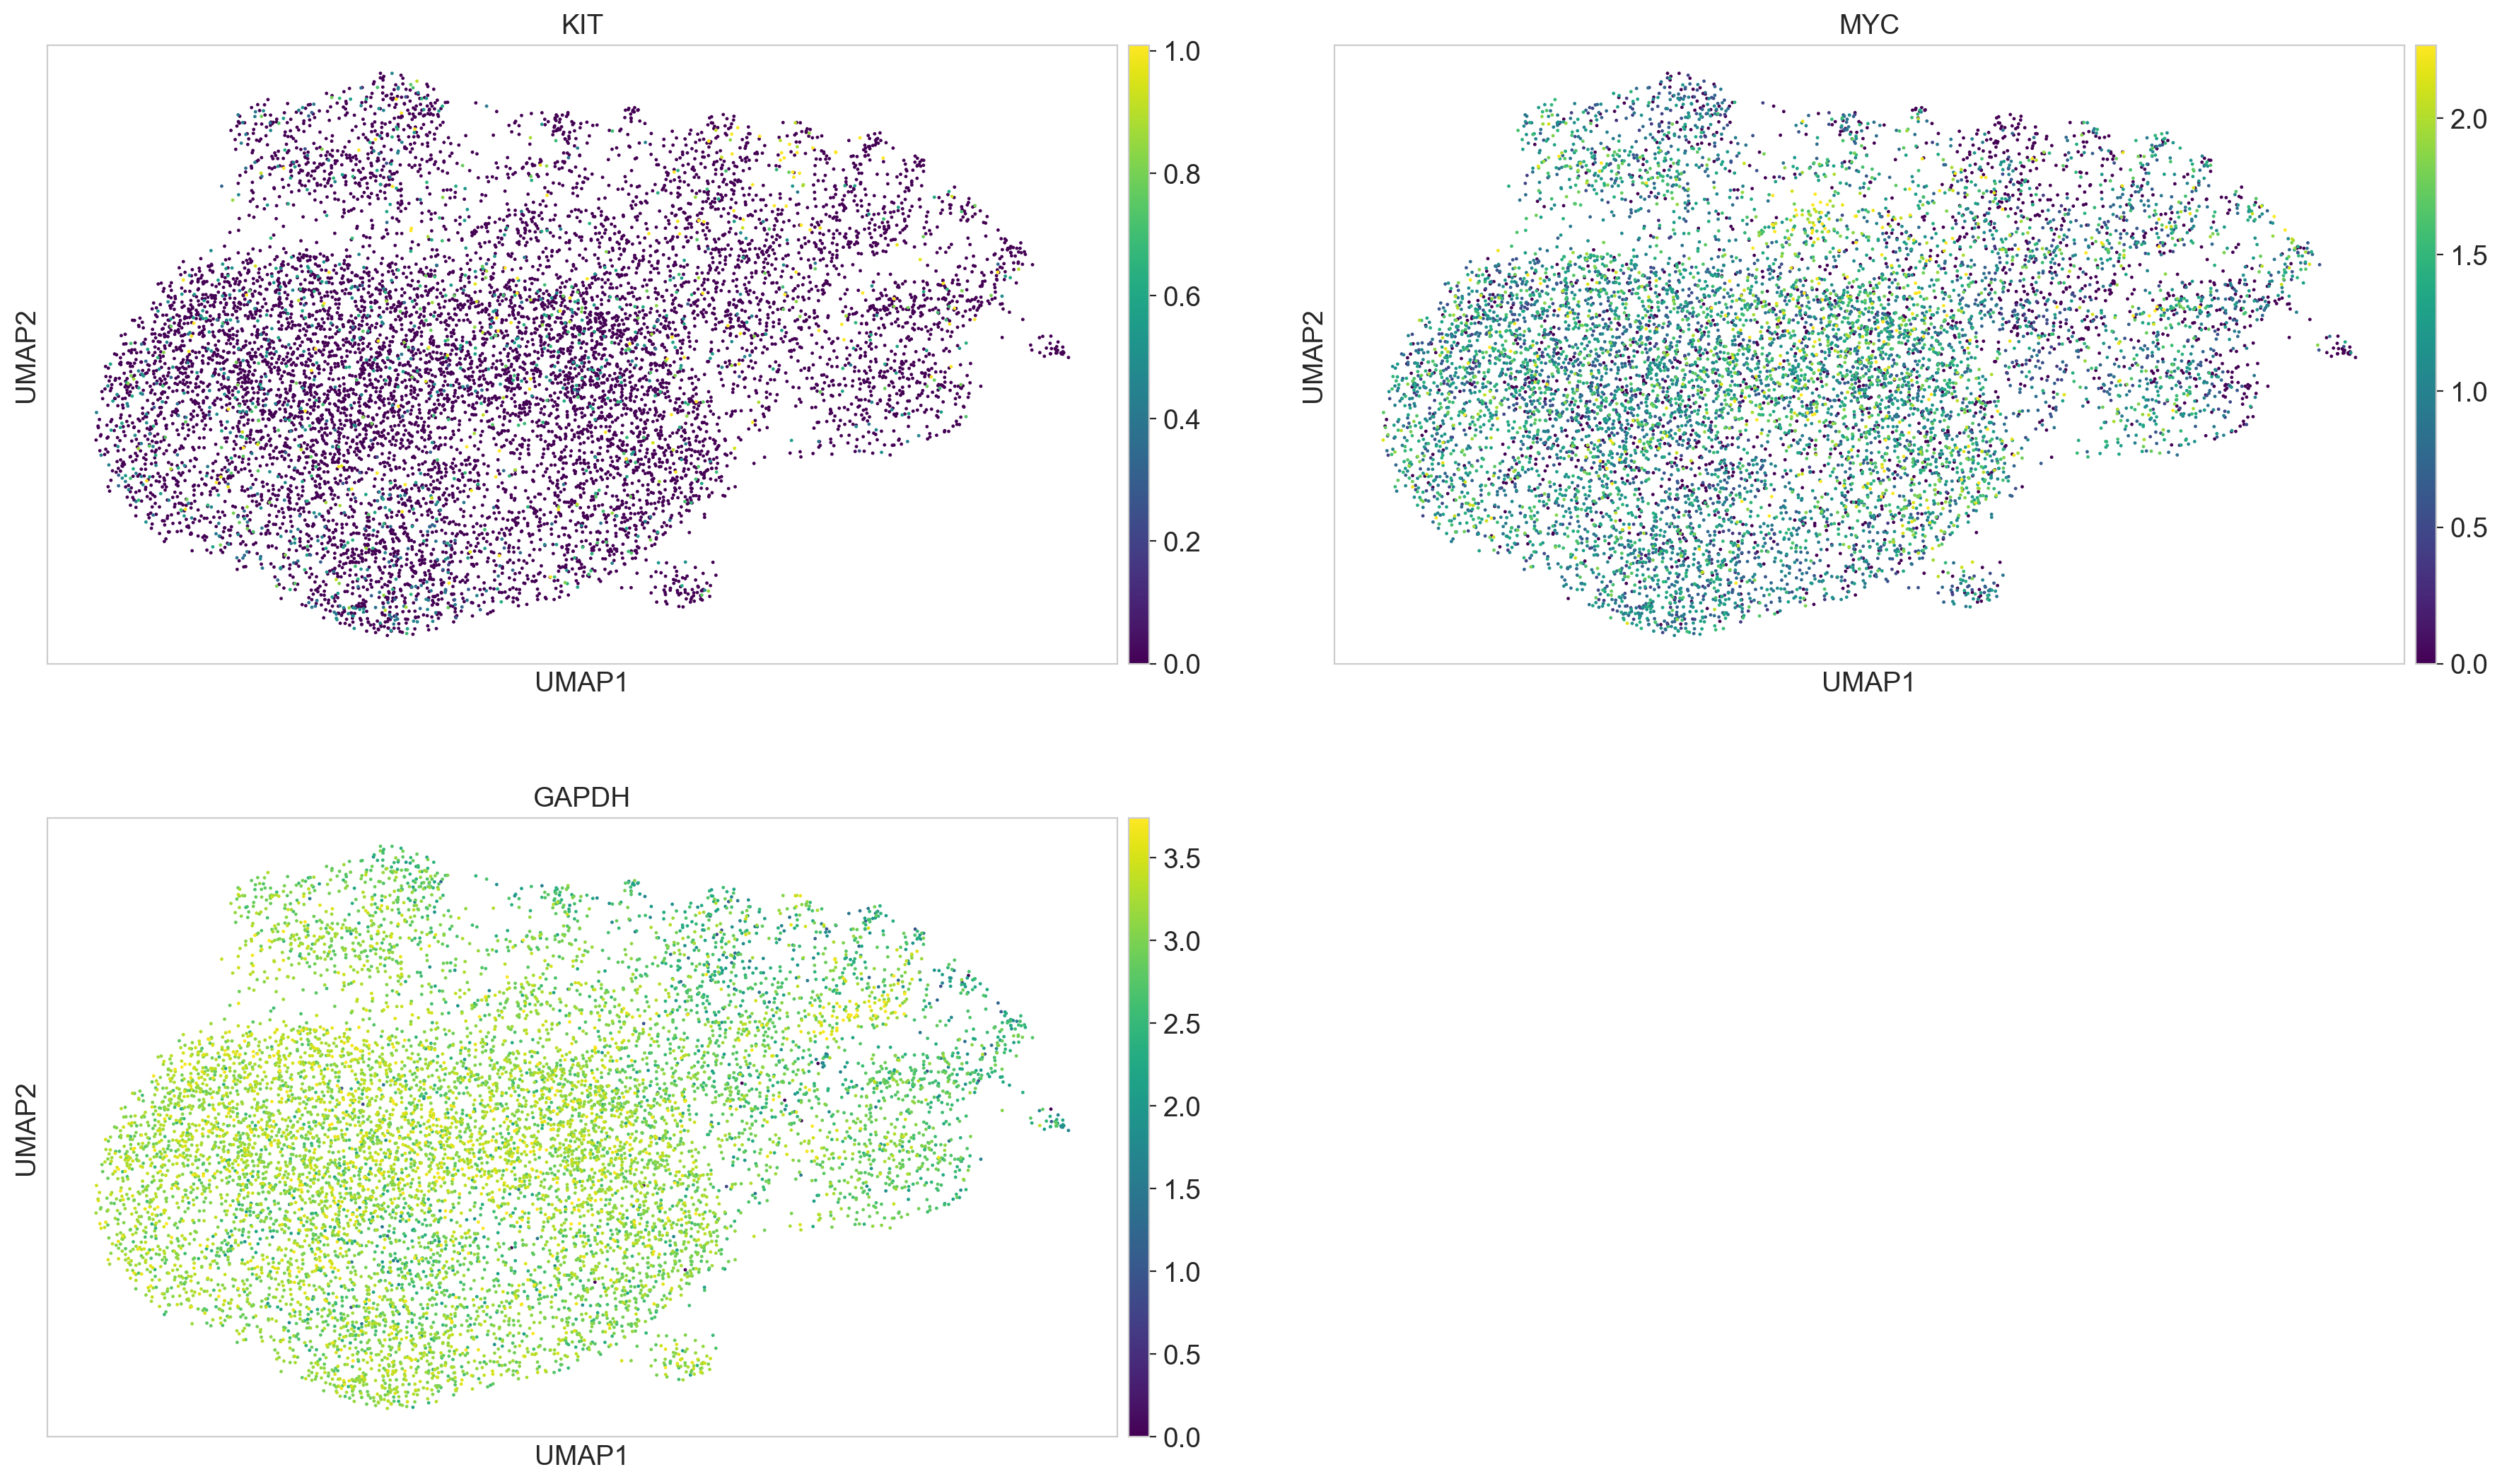

In [14]:
# Find some marker genes to visualize
marker_genes = ['CD34', 'KIT', 'MYC', 'TP53', 'GAPDH']  # Common markers

# Check which markers are present
present_markers = [g for g in marker_genes if g in adata_viz.var_names]

if present_markers:
    print(f"Found {len(present_markers)} marker genes: {present_markers}")
    
    # Plot expression on UMAP
    sc.pl.umap(adata_viz, color=present_markers[:4], ncols=2, 
               vmax='p99', cmap='viridis')
else:
    print("⚠ Marker genes not found in dataset")
    print(f"Example genes: {adata_viz.var_names[:10].tolist()}")

## 7. Compare Control vs Perturbed Cells

Found 1465 control cells


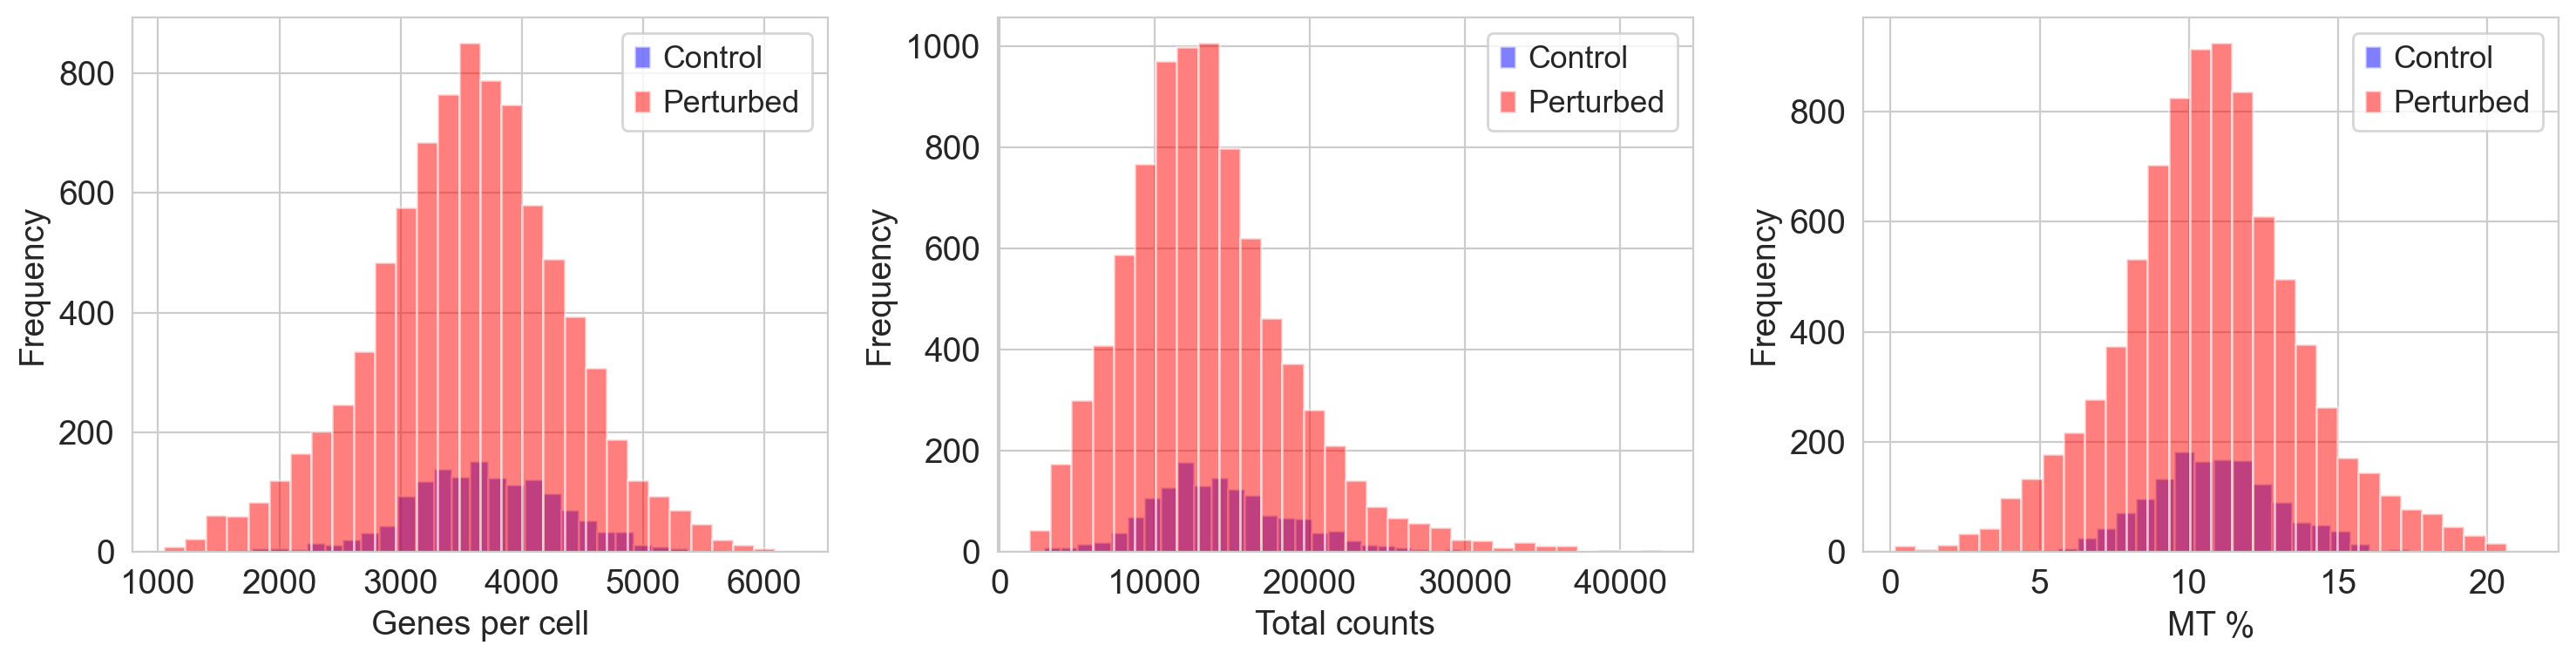

In [15]:
if pert_key:
    # Find control cells (often labeled as 'non-targeting' or 'control')
    control_labels = ['non-targeting', 'control', 'NT', 'negative_control']
    control_mask = adata_viz.obs[pert_key].isin(control_labels)
    
    if control_mask.sum() > 0:
        print(f"Found {control_mask.sum()} control cells")
        
        # Compare QC metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
        titles = ['Genes per cell', 'Total counts', 'MT %']
        
        for ax, metric, title in zip(axes, metrics, titles):
            control_vals = adata_viz.obs.loc[control_mask, metric]
            perturbed_vals = adata_viz.obs.loc[~control_mask, metric]
            
            ax.hist(control_vals, bins=30, alpha=0.5, label='Control', color='blue')
            ax.hist(perturbed_vals, bins=30, alpha=0.5, label='Perturbed', color='red')
            ax.set_xlabel(title)
            ax.set_ylabel('Frequency')
            ax.legend()
        
        plt.tight_layout()
        # plt.show()
    else:
        print("⚠ No control cells found")
        print(f"Unique perturbations: {adata_viz.obs[pert_key].unique()[:10].tolist()}")

## 8. Check Pipeline Outputs

In [16]:
# Check if processed outputs exist
results_dir = Path("../results/demo")

if results_dir.exists():
    print("✓ Results directory found")
    print("\nProcessed files:")
    for file in sorted(results_dir.glob("**/*.h5ad")):
        size_mb = file.stat().st_size / 1e6
        print(f"  {str(file.relative_to(results_dir.parent)):<40} {size_mb:>8.1f} MB")
else:
    print("❌ Results directory not found")
    print("\nRun pipeline: snakemake --cores 4")

✓ Results directory found

Processed files:
  demo\balanced.h5ad                          380.4 MB
  demo\features.h5ad                          381.9 MB
  demo\filtered.h5ad                           48.1 MB
  demo\final.h5ad                             381.3 MB
  demo\normalized.h5ad                        174.3 MB
  demo\scaled.h5ad                            454.0 MB
  demo\splits\test.h5ad                        59.9 MB
  demo\splits\train.h5ad                      269.5 MB
  demo\splits\val.h5ad                         55.6 MB


In [17]:
# Load and compare pipeline stages
stages = {
    'filtered': 'results/demo/filtered.h5ad',
    'normalized': 'results/demo/normalized.h5ad',
    'balanced': 'results/demo/balanced.h5ad',
    'final': 'results/demo/final.h5ad'
}

stage_info = []
for stage_name, stage_path in stages.items():
    full_path = Path('..') / stage_path
    if full_path.exists():
        adata_stage = sc.read_h5ad(full_path)
        stage_info.append({
            'Stage': stage_name,
            'Cells': adata_stage.n_obs,
            'Genes': adata_stage.n_vars,
            'Size (MB)': full_path.stat().st_size / 1e6
        })

if stage_info:
    df_stages = pd.DataFrame(stage_info)
    print("\nPipeline Stages Comparison:")
    print(df_stages.to_string(index=False))
else:
    print("⚠ No processed stages found. Run pipeline first.")


Pipeline Stages Comparison:
     Stage  Cells  Genes  Size (MB)
  filtered   9283   8563  48.084917
normalized   9283   8563 174.282634
  balanced   7810   8563 380.449890
     final   7810   8563 381.294535


## Summary

In this notebook, we:
1. ✓ Loaded the demo Perturb-seq dataset
2. ✓ Explored QC metrics and data quality
3. ✓ Analyzed perturbation distribution
4. ✓ Visualized data with PCA and UMAP
5. ✓ Examined gene expression patterns
6. ✓ Compared control vs perturbed cells
7. ✓ Reviewed pipeline outputs

### Next Steps:

1. **Run full pipeline**: `snakemake --cores 4`
2. **Explore results**: Check `results/demo/` directory
3. **Read QC report**: Open `reports/demo/qc_report.html`
4. **Process your own data**: Add to `config/datasets.yaml`
5. **Train ML models**: Use processed data in `results/demo/final.h5ad`

### Resources:

- [Pipeline Guide](../docs/PIPELINE_GUIDE.md)
- [Troubleshooting](../docs/TROUBLESHOOTING.md)
- [Scanpy Tutorials](https://scanpy-tutorials.readthedocs.io/)
- [Original Paper](https://doi.org/10.1016/j.cell.2022.05.013)